# Social Media Analytics
## Homework 1

In this assignment you are an analytics consultant to a (i) brand manager, (ii) product manager and (iii) advertising manager. Your job is to give advice/insights to these individuals based on the analysis of social media conversations. The detailed tasks are described below. We use cars as an example of a “high involvement” good (recall from class discussions that for high involvement goods, people use social media heavily for awareness building and research). 

#### 1.
Develop a crawler/scraper to fetch messages posted in Edmunds.com discussion forums. The crawler output should be a .csv file with the following columns: date, userid, and message. Before you develop the crawler, carefully study one of the forums on Edmunds.com to understand the html as well as the threading structures.  

In [3]:
# Import statements for Crawler
import urllib2
from bs4 import BeautifulSoup
import csv
import requests 

# Import Statements - Basic
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from collections import defaultdict
import itertools
import sys
import operator

# # Import Statements - nltk
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import word_tokenize
from nltk import collocations
from nltk import sentiment
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

C:\Users\rmaas\Anaconda2\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [4]:
#Edumunds Forum Crawler

def run_edmunds_crawler(url_base):
    cars = open('forum_messages.csv', 'wb') #open csv file connection
    line = csv.writer(cars)

    #scrape the first 600 pages of the forum
    for i in range(1,601):
        new_url = url_base + str(i)
        soup = BeautifulSoup(urllib2.urlopen(new_url).read(), "lxml")

        #each post has a timestamp, user, message
        timestamps = soup.findAll("time")
        users = soup.findAll("a", { "class" : "Username" })
        messages = soup.findAll("div", { "class" : "Message" })

        #each page has multiple posts so it pulls info for each individual post and writes to csv
        for x in range(0, len(timestamps)):
            line_data = [timestamps[x]['datetime'].split('T')[0],
                         users[x].get_text(),
                         messages[x].get_text().lstrip().rstrip()]
            line.writerow([unicode(s).encode("utf-8") for s in line_data])

    cars.close()

#### 2. 
Fetch between 5,000 and 10,000 posts about cars from a General topics forum. Do NOT choose a forum dedicated to a particular brand or model. Instead, you can choose the General & Sedans categories and then select Entry Level Luxury forum https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans. The idea is to have multiple brands and models being discussed without one of them being the focal point. 

In [ ]:
#The base of the url includes everything except for the page number
url_base = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p'

run_edmunds_crawler(url_base)

#### 3. 
Once you fetch the data, find the top 10 brands from frequency counts. You will need to write a script to count the frequencies. Be sure not to count a mention more than once per post, even if it is mentioned multiple times. Replace models with brands so that from now on you have to deal with only brands and not models. You will need another script for this job. This step is meant to help simplify the analysis. A list of model and brand names (not exhaustive) are provided in a separate file.   

In [5]:
# Function to clean up make/model list
def clean(cell):
    cell = cell.lower().rstrip('\xa0')
    return cell

In [6]:
# Create Brand List and Attribute List for Replacements
model_brand = pd.read_csv('cars make model list.csv',header=None, names = ['brand','model'])

model_brand = model_brand.applymap(clean)
carlookupdict = model_brand.set_index('model').to_dict()
carlookupdict = carlookupdict['brand']

brands = list(model_brand['brand'].drop_duplicates())
brands.remove('car')
brands.remove('seat')
brands.remove('problem')
brands.remove('sedan')

# Key attributes were considered to be performance, price, features, country (German, American, etc.) and words that
## fit under that category will be replace with the key attribute
attribute_list = pd.read_csv('attribute list.csv', header=None, names = ['word', 'replace'])
attributelookupdict = attribute_list.set_index('word').to_dict()
attributelookupdict = attributelookupdict['replace']

In [7]:
# Function to Tokenize Words 
def tokenize(line):
    
    stops = list(set(stopwords.words('english'))) # create list of unique stopwords
    tokenizer = RegexpTokenizer(r'\w+') # create tokenizer to remove punctuation
    
    list_of_words = list(set(tokenizer.tokenize(line)))
    list_of_words = [w for w in list_of_words if w not in stops]
    
    return list_of_words
    

In [8]:
# Function to read each line
def read_input(file):
    for line in file:
        # split the line into individual fields (fields are delimited by tab).
        yield line.lower().strip().split(',',2)

# Function to compile word dictionary with each review the word appears in
def main():
    # input comes from STDIN (standard input)
    # data is the generator that produces individual inputs
    data = read_input(INPUT)
    worddict = {}
    i=0
    for line in data:
        try:
            comment = line[2]
        except IndexError:
            continue
            
        wordlist = (tokenize(comment))
        
        for word in set(wordlist):
            if word in carlookupdict.keys():
                word = carlookupdict[word]
            if word in attributelookupdict.keys():
                word = attributelookupdict[word]
                
            if word in worddict.keys(): #RM: check if index is first a value of word key before adding
                if i not in worddict.get(word):
                    worddict[word].append(i)
            else:
                worddict[word] = [i]
        
        #RM: comment because second loop is no longer needed, but don't want to lose code just in case
        '''for word in set(wordlist): # JZ: do dictionary modification after de-duplicating again
            if word in worddict.keys():
                worddict[word].append(i)
            else:
                worddict[word] = [i]'''
        i += 1
    return worddict        

In [9]:
# Function to get frequency counts for each word (number of reviews they appear in)
def get_freq(d):
    
    freq_dict = {}
    for word in d.keys():
        freq_dict[word] = len(d[word])
    
    word_freq = freq_dict.items()
    word_freq.sort(key=operator.itemgetter(1),reverse=True)
#     word_freq = word_freq.rename(columns = {0:"Frequency"})
#     word_freq = word_freq.sort_values('Frequency', ascending = False)
    
    return word_freq


In [10]:
# Function to calculate lift of pairs of words, output is a dataframe 
def get_lift(items, freq_dict):
    lifts = pd.DataFrame(data=None,index=items,columns=items) # initialize empty DF of square matrix
    
    N = max([item for sublist in freq_dict.values() for item in sublist])  # store number of observations total
    
    for a, b in itertools.combinations(items, 2): # for each combination of items in list (no repeats):
        count_x = len(freq_dict[a]) # get count of x
        count_y = len(freq_dict[b]) # get count of y
        overlap = len(list(set(freq_dict[a]) & set(freq_dict[b]))) # get count of (x+y) as intersect of index lists

        lifts[b][a] = (1.0*overlap*N)/(count_x*count_y) # calc lift and store
            
    return lifts

In [11]:
# simple fn to create array from the lift matrix
def build_ds_matrix(lift_matrix):
    mda = np.zeros(shape = lift_matrix.shape) # initialize square array of zeroes 
    
    # loop through each row/col in lift matrix and do the following:
    for i in range(0,len(lift_matrix)):
        for j in range(i,len(lift_matrix)):
            if i == j:
                mda[i,j] = 0 # set the diagonal = 0 (bmw = bmw --> dissimilarity/distance is 0)
            else:
                mda[i,j] = (1.0)/lift_matrix[lift_matrix.columns[j]][i] # grab 1/lift
                mda[j,i] = (1.0)/lift_matrix[lift_matrix.columns[j]][i] # grab 1/lift for the opposite location since it's the same
            
    return mda

In [12]:
# Create word dictionary from reviews
INPUT = open('forum_messages.csv', 'r')
worddict = main()

C:\Users\rmaas\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [13]:
# Get word frequencies for each word in the set of reviews
word_freq = get_freq(worddict)

In [14]:
top_brands = [t for t in word_freq if t[0] in brands]

### Task A
Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. You will have to write a script to do this task). Show the brands on a multi-dimensional scaling (MDS) map. You can use XLSTAT (http://www.xlstat.com/en/learning-center/tutorials/multidimensional-scaling-mds-with-xlstat.html) for MDS analysis. 

In [15]:
# Gather the top 10 brands
top_brands[:10]

[('bmw', 5412),
 ('acura', 2245),
 ('audi', 2177),
 ('honda', 1638),
 ('infiniti', 1587),
 ('toyota', 1110),
 ('nissan', 774),
 ('volkswagen', 611),
 ('mercedes-benz', 586),
 ('ford', 558)]

In [16]:
top_10_brands = [x[0] for x in top_brands[:10]]
top_10_brands

['bmw',
 'acura',
 'audi',
 'honda',
 'infiniti',
 'toyota',
 'nissan',
 'volkswagen',
 'mercedes-benz',
 'ford']

In [17]:
df_brand_freq = pd.DataFrame(top_brands)
df_brand_freq.columns = [['Brand', 'Frequency']]
df_brand_freq = df_brand_freq.set_index('Brand')
df_brand_freq

,Frequency
Brand,
bmw,5412
acura,2245
audi,2177
honda,1638
infiniti,1587
toyota,1110
nissan,774
volkswagen,611
mercedes-benz,586


In [18]:
liftmat = get_lift((top_10_brands), worddict)
liftmat

,bmw,acura,audi,honda,infiniti,toyota,nissan,volkswagen,mercedes-benz,ford
bmw,NaN,1.38308,1.70411,1.24729,1.797,1.48895,1.22212,1.44456,2.17227,1.49985
acura,NaN,NaN,2.22343,3.23971,2.99662,1.70305,2.04808,1.8175,2.31456,1.41284
audi,NaN,NaN,NaN,1.59573,2.39065,1.53573,1.25368,3.82009,3.38635,1.50397
honda,NaN,NaN,NaN,NaN,1.50813,3.69487,3.33242,2.41496,2.12146,2.51941
infiniti,NaN,NaN,NaN,NaN,NaN,1.9014,3.53247,1.9234,3.00818,1.46137
toyota,NaN,NaN,NaN,NaN,NaN,NaN,4.18658,2.16067,2.75023,2.91896
nissan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.69621,1.88815,2.51166
volkswagen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.92338,3.12589
mercedes-benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.67724
ford,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
liftmat_dash = liftmat.copy()
liftmat_dash.fillna('-', inplace=True)
liftmat_dash

,bmw,acura,audi,honda,infiniti,toyota,nissan,volkswagen,mercedes-benz,ford
bmw,-,1.38308,1.70411,1.24729,1.797,1.48895,1.22212,1.44456,2.17227,1.49985
acura,-,-,2.22343,3.23971,2.99662,1.70305,2.04808,1.8175,2.31456,1.41284
audi,-,-,-,1.59573,2.39065,1.53573,1.25368,3.82009,3.38635,1.50397
honda,-,-,-,-,1.50813,3.69487,3.33242,2.41496,2.12146,2.51941
infiniti,-,-,-,-,-,1.9014,3.53247,1.9234,3.00818,1.46137
toyota,-,-,-,-,-,-,4.18658,2.16067,2.75023,2.91896
nissan,-,-,-,-,-,-,-,2.69621,1.88815,2.51166
volkswagen,-,-,-,-,-,-,-,-,2.92338,3.12589
mercedes-benz,-,-,-,-,-,-,-,-,-,2.67724
ford,-,-,-,-,-,-,-,-,-,-


In [20]:
### MDS Section

In [21]:
mda = build_ds_matrix(liftmat)
mda

array([[ 0.        ,  0.72302251,  0.58681627,  0.80174072,  0.55648345,
         0.67161641,  0.81824782,  0.69225112,  0.4603469 ,  0.66673526],
       [ 0.72302251,  0.        ,  0.44975609,  0.30866991,  0.33370968,
         0.58718216,  0.48826331,  0.55020515,  0.43204837,  0.70779255],
       [ 0.58681627,  0.44975609,  0.        ,  0.6266709 ,  0.41829629,
         0.65115621,  0.79765447,  0.26177416,  0.29530349,  0.66490529],
       [ 0.80174072,  0.30866991,  0.6266709 ,  0.        ,  0.66307399,
         0.27064534,  0.30008223,  0.41408527,  0.47137455,  0.39691829],
       [ 0.55648345,  0.33370968,  0.41829629,  0.66307399,  0.        ,
         0.5259272 ,  0.28308798,  0.51991273,  0.33242647,  0.68429065],
       [ 0.67161641,  0.58718216,  0.65115621,  0.27064534,  0.5259272 ,
         0.        ,  0.2388584 ,  0.46281972,  0.36360608,  0.34258786],
       [ 0.81824782,  0.48826331,  0.79765447,  0.30008223,  0.28308798,
         0.2388584 ,  0.        ,  0.37089054

In [22]:
# import package
from sklearn.manifold import MDS

# initialize fit object 
mds1 = MDS(n_components=2, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=1, random_state=None, dissimilarity='euclidean')
md_coords = mds1.fit_transform(mda)


C:\Users\rmaas\Anaconda2\lib\site-packages\sklearn\manifold\mds.py:396: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


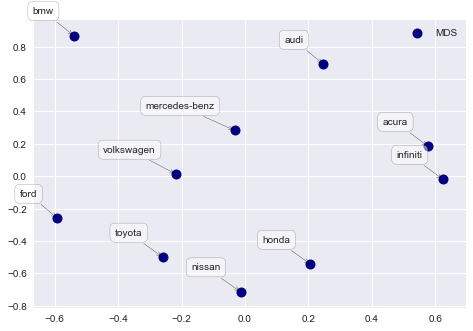

In [23]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

labels = top_10_brands

s = 100
plt.scatter(md_coords[:, 0], md_coords[:, 1], color='navy', s=s, lw=0,
            label='MDS')
plt.legend(scatterpoints=1, loc='best', shadow=False)


for label, x, y in zip(labels, md_coords[:, 0], md_coords[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()

### Task B
What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)? 

### Task C
What are 5 most frequently mentioned attributes of cars in the discussions? Note that the same attribute may be described by different words – e.g., pick-up and acceleration may both refer to a more general attribute, “performance”. You have to make suitable replacements. Now pick the 5 most frequently mentioned brands. Which attributes are most strongly associated with which of these 5 brands? You don’t have to do a sentiment analysis for this assignment.

**While BMW has claimed that they are the “ultimate driving machine”, is that how people feel on Edmunds? Show your analysis.**

In [24]:
top_words = [t for t in word_freq]
top_words.sort(key=lambda x: x[1], reverse=True)
top_words[:80]

[('car', 8720),
 ('performance', 8020),
 ('quality', 6877),
 ('features', 5596),
 ('bmw', 5412),
 ('price', 4648),
 ('like', 4575),
 ('one', 4327),
 ('would', 3960),
 ('get', 3712),
 ('3', 3591),
 ('think', 3197),
 ('even', 2635),
 ('much', 2566),
 ('well', 2548),
 ('tl', 2498),
 ('better', 2464),
 ('good', 2438),
 ('know', 2308),
 ('acura', 2245),
 ('really', 2202),
 ('audi', 2177),
 ('also', 2115),
 ('time', 2072),
 ('people', 2026),
 ('sedan', 2020),
 ('series', 1989),
 ('2', 1971),
 ('5', 1947),
 ('still', 1902),
 ('see', 1899),
 ('want', 1892),
 ('years', 1824),
 ('way', 1822),
 ('said', 1812),
 ('make', 1770),
 ('could', 1760),
 ('go', 1733),
 ('say', 1708),
 ('back', 1689),
 ('best', 1638),
 ('honda', 1638),
 ('4', 1619),
 ('6', 1606),
 ('infiniti', 1587),
 ('going', 1521),
 ('buy', 1494),
 ('1', 1494),
 ('right', 1486),
 ('many', 1476),
 ('lexus', 1471),
 ('g35', 1466),
 ('fuel', 1442),
 ('less', 1440),
 ('great', 1417),
 ('year', 1387),
 ('sure', 1336),
 ('take', 1336),
 ('nev

The 5 most important features for a car:
1. Performance (8,000+ mentions)
2. Quality (6,800+ mentions)
3. Features (5,500+ mentions)
4. Price (4,600+ mentions)
5. Fuel/Oil Efficiency (1,400+ mentions)  

Comparing these with the top 5 brands:
1. BMW
2. Acura
3. Audi
4. Honda
5. Infiniti

In [25]:
get_lift(('performance', 'quality', 'features', 'price', 'fuel', 'bmw', 'acura', 'audi', 'honda', 'infiniti'), worddict)

,performance,quality,features,price,fuel,bmw,acura,audi,honda,infiniti
performance,NaN,1.35331,1.53715,1.29113,1.58964,1.38641,1.35083,1.41265,1.39074,1.41599
quality,NaN,NaN,1.46527,1.50334,1.54104,1.36577,1.50386,1.53558,1.59654,1.50835
features,NaN,NaN,NaN,1.46701,1.32778,1.41324,1.4088,1.62308,1.40767,1.56862
price,NaN,NaN,NaN,NaN,1.6781,1.59481,1.67426,1.65884,1.61728,1.82406
fuel,NaN,NaN,NaN,NaN,NaN,1.39731,1.18162,1.37008,1.70006,1.71312
bmw,NaN,NaN,NaN,NaN,NaN,NaN,1.38308,1.70411,1.24729,1.797
acura,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.22343,3.23971,2.99662
audi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.59573,2.39065
honda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.50813
infiniti,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
att_brand_lift = get_lift(('performance', 'quality', 'features', 'price', 'fuel', 'bmw', 'acura', 'audi', 'honda', 'infiniti'), worddict)
att_brand_lift.fillna('-')

,performance,quality,features,price,fuel,bmw,acura,audi,honda,infiniti
performance,-,1.35331,1.53715,1.29113,1.58964,1.38641,1.35083,1.41265,1.39074,1.41599
quality,-,-,1.46527,1.50334,1.54104,1.36577,1.50386,1.53558,1.59654,1.50835
features,-,-,-,1.46701,1.32778,1.41324,1.4088,1.62308,1.40767,1.56862
price,-,-,-,-,1.6781,1.59481,1.67426,1.65884,1.61728,1.82406
fuel,-,-,-,-,-,1.39731,1.18162,1.37008,1.70006,1.71312
bmw,-,-,-,-,-,-,1.38308,1.70411,1.24729,1.797
acura,-,-,-,-,-,-,-,2.22343,3.23971,2.99662
audi,-,-,-,-,-,-,-,-,1.59573,2.39065
honda,-,-,-,-,-,-,-,-,-,1.50813
infiniti,-,-,-,-,-,-,-,-,-,-


In [27]:
att_brand_lift = att_brand_lift[['bmw', 'acura', 'audi', 'honda', 'infiniti']]
att_brand_lift[:5]

,bmw,acura,audi,honda,infiniti
performance,1.38641,1.35083,1.41265,1.39074,1.41599
quality,1.36577,1.50386,1.53558,1.59654,1.50835
features,1.41324,1.4088,1.62308,1.40767,1.56862
price,1.59481,1.67426,1.65884,1.61728,1.82406
fuel,1.39731,1.18162,1.37008,1.70006,1.71312


### Task D
What advice will you give to a (i) product manager, and (ii) marketing/advertising manager of these brands based on your analysis in Task C?

### Task E
Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?

In [29]:
asp_brand_lift = get_lift(('buy', 'want', 'get', 'purchase', 'love', 'desire',
                           'best', 'goal', 'bmw', 'acura', 'audi', 'honda',
                           'infiniti'), worddict)
asp_brand_lift.fillna('-', inplace=True)
asp_brand_lift = asp_brand_lift[['bmw', 'acura', 'audi', 'honda','infiniti']]
asp_brand_lift[:8]

,bmw,acura,audi,honda,infiniti
buy,1.66878,1.46958,1.5506,1.75754,1.66152
want,1.61697,1.49648,1.765,1.62118,1.82539
get,1.47971,1.39762,1.52841,1.58063,1.6282
purchase,1.52623,1.38341,1.39627,2.01709,1.58225
love,1.54829,1.8135,1.8484,1.96531,1.8644
desire,1.64356,1.47427,1.9004,1.64174,1.30346
best,1.49631,1.506,1.68646,1.57466,1.66919
goal,2.45333,1.97141,1.21979,1.89137,2.78879


Provide the following details in your write-up (I am not setting a strict page limit, but 3-4 pages, single-spaced, 11 font size should be enough with screenshots)

1.	Which forum you chose (provide URL) 
2.	Which 10 brands you chose – provide the frequency table
3.	Show all lift ratio calculations in a table. 
4.	Show the MDS map (put screenshots in your report) 
5.	State the 5 attributes you chose (again, a table is good here). 
6.	For task E, provide all details of your analysis – e.g., how you measured “aspirational” and how you found the most aspirational brand.  
7.	Advice/insights based on your analysis for brand, product and advertising managers. 

Your submission should include multiple files: (i) a Word or pdf file with the above information, (ii) all scripts written for the analysis (generally speaking, I won’t run these scripts, but if the numbers don’t look right, I may run some of them), (ii) Final data file after all replacements have been done.  
